  <blockquote><h1> LOCALISATION DE SOURCE </h1></blockquote>
 

## Bibliotheques 

In [1]:
# pip install libusb1 numpy matplotlib sounddevice

In [1]:
from core import Mu32
import numpy as np
import matplotlib.pyplot as plt
from glob import * 
import examples.mu32autotest as autotest
import logging
from core import Mu32, Mu32Exception, mu32log
import BF_algo as bf
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io

ModuleNotFoundError: No module named 'core'

# 

2022-01-31 17:03:52,509 [INFO]: --------------------
2022-01-31 17:03:52,509 [INFO]: Mu32: end
2022-01-31 17:03:52,509 [INFO]: Mu32: Start running recording...
2022-01-31 17:03:52,509 [INFO]: --------------------
2022-01-31 17:03:52,509 [INFO]: Mu32: sampling frequency: 50000 Hz
2022-01-31 17:03:52,509 [INFO]:  .desired recording duration: 5 s
2022-01-31 17:03:52,515 [INFO]:  .minimal recording duration: 4.997120 s
2022-01-31 17:03:52,517 [INFO]:  .datatype: int32
2022-01-31 17:03:52,518 [INFO]:  .number of USB transfer buffers: 8
2022-01-31 17:03:52,518 [INFO]:  .buffer length in samples number: 512 (10.240000 ms duration)
2022-01-31 17:03:52,523 [INFO]:  .minimal transfers count: 488
2022-01-31 17:03:52,524 [INFO]:  .7 activated microphones
2022-01-31 17:03:52,525 [INFO]:  .activated microphones: (0, 1, 2, 3, 4, 5, 6)
2022-01-31 17:03:53,559 [WARNING]: in core (core.py:442): Mu32: got 875 samples against 3584 samples desired. Complete without processing data
2022-01-31 17:03:53,559 [

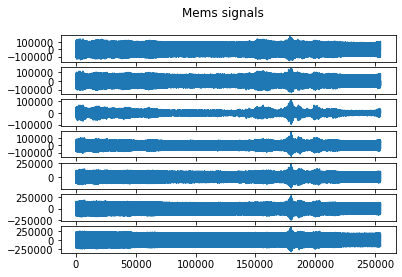

L'angle : 62


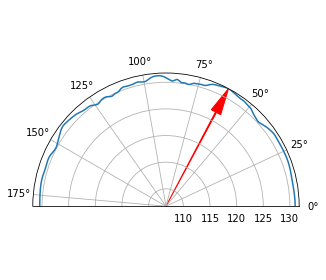

In [50]:



# vitesse du son
c0 = 340.

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# lecture des 7 signaux de sortie des microphones
signal=[]
File_wave_name=["signal0.wav","signal1.wav","signal2.wav",
                "signal3.wav","signal4.wav","signal5.wav","signal6.wav"]

for i in range (len(File_wave_name)):
    samplerate, data = wavfile.read(File_wave_name[i])
    signal.append(data)


# Création du vecteur d'échantillons de temps 
fs = 44100     # freq d'échantillonnage [Hz]
dt = 1./fs      # résolution temporelle [s]
T = 5          # durée de l'enregistrement [s]

N_time = int(T*fs)
p_array=np.array(signal)

# vecteur d'échantillons de temps

t = np.linspace(0, T-dt, N_time)
p_array=p_array[0:441000]

# création d'un tableau linéaire uniforme (Antenne)

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Taille du tableau [mettre]

L = 0.36  
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Nombre de capteurs mems dans le tableau d'antenne (doit être impair !)  

M = 7   
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
MyULA = bf.Antenne(L, M)
# utiliser le beamforming à retardement et à somme pour déterminer la direction d'arrivée

N_theta = 181
theta = np.linspace(0, np.pi, N_theta)

weights = np.ones(M)
y_beamformer,y_energie_dB,angle= bf.beamforming(MyULA, p_array, theta, weights, fs)

dB_max = y_energie_dB.max()
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Plage dynamique du tracé polaire
dyn_range = 25      # dB
# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, y_energie_dB)
theta0_deg= 90
# ajouter une flèche indiquant la direction d'arrivée du signal
ax.arrow(angle*np.pi/180, dB_max-dyn_range, 0, dyn_range, width=0.01,
         head_width=0.1, head_length=5,
         length_includes_head=True, edgecolor = 'red', facecolor = 'red')

ax.set_rmax(dB_max)
ax.set_rmin(dB_max - dyn_range)

ax.set_thetamin(0)
ax.set_thetamax(180)
fig.set_tight_layout(True)

print(f"L'angle : {angle}")




# Processing data

In [ ]:
MEMS=(0, 1, 2, 3,4,5,6)
MEMS_NUMBER = len( MEMS )
DURATION = 1

In [ ]:

def post_callback_plot( mu32: Mu32 ):
    print( 'Plot power on (0, 1, 2, 3,4,5,6) microphones' )
    q_size = mu32.signal_q.qsize()
    if q_size== 0:
        raise Exception( 'No received data !' )
    """
    get queued signals
    """
    signal = []
    for _ in range( q_size ):
        signal = np.append( signal, mu32.signal_q.get( block=False ) )
    samples_number = int( len( signal )/mu32.mems_number )
    print( 'mems_number=', mu32.mems_number )
    print( 'samples_number=', samples_number )
    print( 'sampling_frequency=', mu32.sampling_frequency )
    print( 'clockdiv=', mu32.clockdiv )
    print( 'buffer_length=', mu32.buffer_length )
    print( 'buffers_number=', mu32.buffers_number )
    signal = signal.reshape( samples_number, MEMS_NUMBER )
    """
    plot signals
    """
    fig, axs = plt.subplots( MEMS_NUMBER )
    fig.suptitle( 'Mems power' )
    time = np.array( [t for t in range( samples_number )] )*mu32.buffer_length/mu32.sampling_frequency
    for s in range( MEMS_NUMBER ):
        axs[s].plot( time, signal[:,s] )
    plt.show()

In [ ]:

mu32: Mu32 = Mu32()
mu32.run(
    mems=MEMS,
    duration=DURATION,
    post_callback_fn=post_callback_plot,
    callback_fn=mu32.callback_power
)

In [ ]:
def your_callback_power( self, mu32, data: np.ndarray ):
    """
    Compute energy (mean power) on transfered frame
    """
    signal = data.reshape( mu32.buffer_length, mu32.mems_number )
    signal = np.float32( signal )/np.float32( 0x07FF )
    mean_power = np.sum( signal**2, axis=0 ) / mu32.buffer_length
    self.signal_q.put( mean_power )